In [75]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax

In [76]:
# feature engineering for 13 files
datas = []
for i in range(1, 14):
    new_instances = pd.read_csv(str(i) + '_new_instances.csv')
    edge_index = np.loadtxt(str(i) +'_edge_index.csv', delimiter=',')
    # normalize xloc, yloc, congestion, width, height
    # use one hot encoding for orient
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()

    scaler = MinMaxScaler()
    node_features = scaler.fit_transform(new_instances[['xloc', 'yloc', 'width', 'GRC_density', 'node_degree']])
    node_features = np.concatenate((node_features, orient), axis=1)
    demand = new_instances[['routing_demand']].values
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(demand, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=y)
    datas.append(data)


In [77]:
datas

[Data(x=[3952, 9], edge_index=[2, 141472], y=[3952, 1]),
 Data(x=[6872, 9], edge_index=[2, 115420], y=[6872, 1]),
 Data(x=[6913, 9], edge_index=[2, 126081], y=[6913, 1]),
 Data(x=[7323, 9], edge_index=[2, 120929], y=[7323, 1]),
 Data(x=[7258, 9], edge_index=[2, 121094], y=[7258, 1]),
 Data(x=[7120, 9], edge_index=[2, 116592], y=[7120, 1]),
 Data(x=[7879, 9], edge_index=[2, 122335], y=[7879, 1]),
 Data(x=[7626, 9], edge_index=[2, 119388], y=[7626, 1]),
 Data(x=[7620, 9], edge_index=[2, 119652], y=[7620, 1]),
 Data(x=[7772, 9], edge_index=[2, 121838], y=[7772, 1]),
 Data(x=[7814, 9], edge_index=[2, 115804], y=[7814, 1]),
 Data(x=[6529, 9], edge_index=[2, 115553], y=[6529, 1]),
 Data(x=[6548, 9], edge_index=[2, 113626], y=[6548, 1])]

In [78]:
# set of GCN

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.6):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Add self-loops to the edge_index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = F.relu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)

        return x

In [79]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.6):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [80]:
gcn_vloss_lst = []
gcn_tloss_lst = []
gat_vloss_lst = []
gat_tloss_lst = []
gcn_testloss_lst = []
gat_testloss_lst = []
gcn_rmse_lst = []
gat_rmse_lst = []
gcn_pearson_lst = []
gat_pearson_lst = []
gcn_kendall_lst = []
gat_kendall_lst = []
naive_mse_lst = [] 

In [81]:
len(datas[0].x)

3952

In [82]:
datas[0]

Data(x=[3952, 9], edge_index=[2, 141472], y=[3952, 1])

1
2
3
4
5
6
7
8
9
10


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_57741/2353494732.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 5))


11
12
13


<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

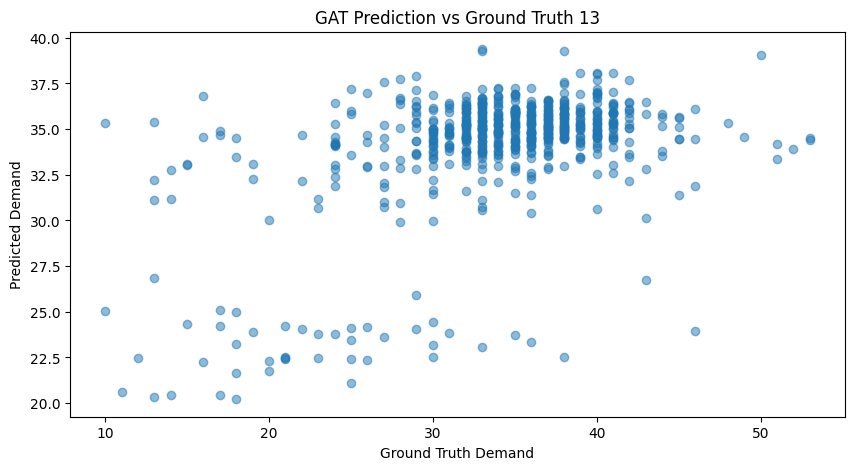

In [83]:
# set random seed
i = 1
for data in datas:
    print(i)
    torch.manual_seed(0)

    num_nodes =  len(data.x)
    train_size = int(num_nodes * 0.8)  # Let's say 80% for training
    val_size = int(num_nodes * 0.1)  # 10% for validation

    # Create a random permutation of node indices
    perm = torch.randperm(num_nodes)

    # Use the first 80% of randomly permuted indices for training
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm[:train_size]] = True

    # Next 10% for validation
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask[perm[train_size:train_size+val_size]] = True

    # Last 10% for testing
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask[perm[train_size+val_size:]] = True

    # Assign masks to your data object
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    #GCN model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    GCN_model = GCN(in_channels=9, hidden_channels=9, out_channels=1, dropout=0).to(device)
    GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.005, weight_decay=5e-4)

    GCN_loss_values = []
    GCN_valid_loss_values = []

    GCN_model.train()
    for epoch in range(300):
        GCN_optimizer.zero_grad()
        GCN_out = GCN_model(data)
        GCN_loss = F.mse_loss(GCN_out[data.train_mask], data.y[data.train_mask])
        GCN_valid_loss = F.mse_loss(GCN_out[data.val_mask], data.y[data.val_mask])
        GCN_loss.backward()
        GCN_optimizer.step()
        GCN_loss_values.append(GCN_loss.item())
        GCN_valid_loss_values.append(GCN_valid_loss.item())
        # print(f'Epoch {epoch+1}, Loss: {GCN_loss.item()}')
    gcn_vloss_lst.append(GCN_valid_loss_values[-1])
    gcn_tloss_lst.append(GCN_loss_values[-1])

    #GAT model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    GAT_model = GAT(in_channels=9, hidden_channels=9, out_channels=1, heads=9, dropout=0).to(device)
    GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)

    GAT_loss_values = []
    GAT_valid_loss_values = []

    GAT_model.train()
    for epoch in range(300):
        GAT_optimizer.zero_grad()
        GAT_out = GAT_model(data)
        GAT_loss = F.mse_loss(GAT_out[data.train_mask], data.y[data.train_mask])
        GAT_valid_loss = F.mse_loss(GAT_out[data.val_mask], data.y[data.val_mask])
        GAT_loss.backward()
        GAT_optimizer.step()
        GAT_loss_values.append(GAT_loss.item())
        GAT_valid_loss_values.append(GAT_valid_loss.item())
        # print(f'Epoch {epoch+1}, Loss: {GAT_loss.item()}')
    gat_vloss_lst.append(GAT_valid_loss_values[-1])
    gat_tloss_lst.append(GAT_loss_values[-1])

    plt.clf()
    plt.plot(GCN_loss_values, label='Training Loss', color='blue', alpha=0.5)
    plt.plot(GCN_valid_loss_values, label='Validation Loss', color='red', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'GCN Training and Validation Loss {i}')
    plt.legend()
    plt.savefig(f"GCN_TV_loss/{i}.pdf")
    # plt.show()


    plt.clf()
    plt.plot(GAT_loss_values, label='Training Loss', color='blue', alpha=0.5)
    plt.plot(GAT_valid_loss_values, label='Validation Loss', color='red', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'GAT Training and Validation Loss {i}')
    plt.legend()
    plt.savefig(f"GAT_TV_loss/{i}.pdf")
    # plt.show()

    # Evaluate the model
    GCN_model.eval()
    GCN_out = GCN_model(data)
    GCN_loss = F.mse_loss(GCN_out[data.test_mask], data.y[data.test_mask])
    # print(f'GCN_Test Loss: {GCN_loss.item()}')
    gcn_testloss_lst.append(GCN_loss)
    
    GAT_model.eval()
    GAT_out = GAT_model(data)
    GAT_loss = F.mse_loss(GAT_out[data.test_mask], data.y[data.test_mask])
    # print(f'GAT_Test Loss: {GAT_loss.item()}')
    gat_testloss_lst.append(GAT_loss)

    # plot the distribution of original congestion and predicted congestion
    plt.clf()
    plt.figure(figsize=(10, 5))
    sns.histplot(data.y[data.test_mask].cpu().detach().numpy(), kde=True, label='Ground Truth Demand', stat="density", color='blue')
    sns.histplot(GCN_out[data.test_mask].cpu().detach().numpy().flatten(), kde=True, label='Predicted Demand', stat="density", color='red')
    plt.xlabel('Demand')
    plt.ylabel('Frequency')
    plt.title(f'GCN Prediction vs Ground Truth {i}')
    plt.legend()
    plt.savefig(f"GCN_hist/{i}.pdf")
    # plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    sns.histplot(data.y[data.test_mask].cpu().detach().numpy(), kde=True, label='Ground Truth Demand', stat="density", color='blue')
    sns.histplot(GAT_out[data.test_mask].cpu().detach().numpy().flatten(), kde=True, label='Predicted Demand', stat="density", color='red')
    plt.xlabel('Congestion')
    plt.ylabel('Frequency')
    plt.title(f'GAT Prediction vs Ground Truth {i}')
    plt.legend()
    plt.savefig(f"GAT_hist/{i}.pdf")
    # plt.show()

    plt.clf()
    plt.scatter(data.y[data.test_mask].cpu().detach().numpy(), GCN_out[data.test_mask].cpu().detach().numpy(), alpha=0.5)
    plt.xlabel('Ground Truth Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'GCN Prediction vs Ground Truth {i}')
    plt.savefig(f"GCN_scatter/{i}.pdf")
    # plt.show()

    plt.clf()
    plt.scatter(data.y[data.test_mask].cpu().detach().numpy(), GAT_out[data.test_mask].cpu().detach().numpy(), alpha=0.5)
    plt.xlabel('Ground Truth Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'GAT Prediction vs Ground Truth {i}')
    plt.savefig(f"GAT_scatter/{i}.pdf")

    # calculate Pearson correlation coefficient, kendall correlation coefficient, and test RMSE
    from sklearn.metrics import mean_squared_error
    from scipy.stats import pearsonr, kendalltau

    GCN_rmse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), GCN_out[data.test_mask].cpu().detach().numpy(), squared=False)
    GAT_rmse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), GAT_out[data.test_mask].cpu().detach().numpy(), squared=False)
    gcn_rmse_lst.append(GCN_rmse)
    gat_rmse_lst.append(GAT_rmse)
    
    GCN_pearson = pearsonr(data.y[data.test_mask].cpu().detach().numpy().flatten(), GCN_out[data.test_mask].cpu().detach().numpy().flatten())
    GAT_pearson = pearsonr(data.y[data.test_mask].cpu().detach().numpy().flatten(), GAT_out[data.test_mask].cpu().detach().numpy().flatten())
    gcn_pearson_lst.append(GCN_pearson)
    gat_pearson_lst.append(GAT_pearson)

    GCN_kendall = kendalltau(data.y[data.test_mask].cpu().detach().numpy().flatten(), GCN_out[data.test_mask].cpu().detach().numpy().flatten())
    GAT_kendall = kendalltau(data.y[data.test_mask].cpu().detach().numpy().flatten(), GAT_out[data.test_mask].cpu().detach().numpy().flatten())
    gcn_kendall_lst.append(GCN_kendall)
    gat_kendall_lst.append(GAT_kendall)

    # print(f'GCN RMSE: {GCN_rmse}')
    # print(f'GAT RMSE: {GAT_rmse}')
    # print(f'GCN Pearson Correlation: {GCN_pearson}')
    # print(f'GAT Pearson Correlation: {GAT_pearson}')
    # print(f'GCN Kendall Correlation: {GCN_kendall}')
    # print(f'GAT Kendall Correlation: {GAT_kendall}')

    average_demand = data.y[data.train_mask].mean()
    naive_mse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), np.full(data.y[data.test_mask].shape, average_demand), squared=False)
    naive_mse_lst.append(naive_mse)
    i += 1


In [85]:
len(gcn_vloss_lst)

13

In [86]:
data_dict = {
    'GCN Validation Loss': gcn_vloss_lst,
    'GCN Training Loss': gcn_tloss_lst,
    'GAT Validation Loss': gat_vloss_lst,
    'GAT Training Loss': gat_tloss_lst,
    'GCN Test Loss': gcn_testloss_lst,
    'GAT Test Loss': gat_testloss_lst,
    'GCN RMSE': gcn_rmse_lst,
    'GAT RMSE': gat_rmse_lst,
    'GCN Pearson Correlation': gcn_pearson_lst,
    'GAT Pearson Correlation': gat_pearson_lst,
    'GCN Kendall Correlation': gcn_kendall_lst,
    'GAT Kendall Correlation': gat_kendall_lst,
    'Naive MSE': naive_mse_lst
}


In [139]:
gcn_kendall_lst[0].correlation

0.03212743718312684

In [95]:
[x.item() for x in gcn_testloss_lst]

[82.5930404663086,
 156.06398010253906,
 101.68577575683594,
 100.22688293457031,
 92.4005355834961,
 104.58889770507812,
 87.83980560302734,
 70.71910858154297,
 82.80689239501953,
 74.54288482666016,
 82.38858032226562,
 115.28025817871094,
 127.6473388671875]

In [100]:
df = pd.DataFrame({
    'GCN Validation Loss': gcn_vloss_lst,
    'GCN Training Loss': gcn_tloss_lst,
    'GAT Validation Loss': gat_vloss_lst,
    'GAT Training Loss': gat_tloss_lst,
    'GCN Test Loss': [x.item() for x in gcn_testloss_lst],
    'GAT Test Loss': [x.item() for x in gat_testloss_lst],
    'GCN RMSE': gcn_rmse_lst,
    'GAT RMSE': gat_rmse_lst,
    'GCN Pearson Correlation': gcn_pearson_lst,
    'GAT Pearson Correlation': gat_pearson_lst,
    'GCN Kendall Correlation': gcn_kendall_lst,
    'GAT Kendall Correlation': gat_kendall_lst,
    'Naive MSE': naive_mse_lst
})


In [118]:
df

,GCN Validation Loss,GCN Training Loss,GAT Validation Loss,GAT Training Loss,GCN Test Loss,GAT Test Loss,GCN RMSE,GAT RMSE,GCN Pearson Correlation,GAT Pearson Correlation,GCN Kendall Correlation,GAT Kendall Correlation,Naive MSE
0,80.786369,75.367897,15.404597,15.083115,82.593040,13.418016,9.088072,3.663061,"(-0.005031678817587823, 0.9204925871981983)","(0.47195434172140216, 2.3320367404661053e-23)","(0.03212743718312684, 0.35683912141120266)","(0.18069854213598832, 2.1907534855328953e-07)",4.137239
1,152.361282,157.347336,67.185555,68.382462,156.063980,68.600700,12.492557,8.282554,"(0.19101646581255835, 4.470331536171664e-07)","(0.501405676905146, 4.443622161069172e-45)","(0.10927863034449381, 2.4075393372262846e-05)","(0.16714492218695684, 1.0493914252799394e-10)",9.560718
2,94.724586,96.844482,49.802460,45.912956,101.685776,45.536194,10.083937,6.748051,"(0.1281308813297367, 0.0007289867367615492)","(0.42156144924688727, 3.447698740148198e-31)","(0.07872694538879924, 0.0023595597536521656)","(0.18758711655557975, 4.309472851783489e-13)",7.443776
3,89.079269,101.390366,42.032089,45.887329,100.226883,48.603859,10.011337,6.971647,"(0.1496209625348237, 4.765617016849745e-05)","(0.4112620218002705, 2.7603143174215377e-31)","(0.08826428954984666, 0.000445215982023587)","(0.18565019745329303, 1.509056539819414e-13)",7.652159
4,96.391975,93.452148,43.544693,44.562378,92.400536,45.082619,9.612519,6.714359,"(0.15042285225976065, 4.6600365602581596e-05)","(0.4437336963530267, 2.000620089717218e-36)","(0.08665027581925358, 0.0005975393954277547)","(0.23576971446611814, 9.61251674925391e-21)",7.479195
5,103.954369,99.037033,41.386799,44.957748,104.588898,47.200920,10.226871,6.870293,"(0.1830700948543973, 8.745193334868589e-07)","(0.5234160845345861, 2.487539080044007e-51)","(0.09834634365085486, 0.0001143851754414654)","(0.24736107773431096, 2.919080333451329e-22)",8.035375
6,81.787262,88.088928,28.388975,33.054199,87.839806,33.911674,9.372290,5.823372,"(0.19587661883875532, 2.9043929820946495e-08)","(0.46745501756942653, 4.431787008234224e-44)","(0.100269732443074, 4.04270642997841e-05)","(0.18381846324958137, 5.252067909881322e-14)",6.557995
7,78.609390,71.833656,29.684155,29.228073,70.719109,25.797934,8.409466,5.079166,"(0.2267276149038831, 2.307374498851639e-10)","(0.5259934885087192, 1.398809285406174e-55)","(0.12059512579232488, 1.1413365532406225e-06)","(0.2421099642875629, 1.5412817770145804e-22)",5.972166
8,93.503937,90.368584,47.995113,47.284996,82.806892,48.201950,9.099830,6.942762,"(0.27622207611469574, 8.231680450087378e-15)","(0.4618955170035156, 1.5570008792025662e-41)","(0.17341106085130656, 1.974445155705518e-12)","(0.22599572398657972, 4.733654265920126e-20)",7.832735
9,78.242058,78.026192,41.612400,42.337914,74.542885,40.973686,8.633822,6.401069,"(0.16119917769250397, 6.22421834608526e-06)","(0.34159015365495665, 1.0287587896812533e-22)","(0.1071465585923039, 1.1633092351409582e-05)","(0.17963183058606308, 1.976239816820343e-13)",6.808980


In [119]:
df.to_csv('integrated_results.csv')

In [121]:
test = pd.read_csv('integrated_results.csv')
test['GCN Pearson Correlation']

0     PearsonRResult(statistic=-0.005031678817587823...
1     PearsonRResult(statistic=0.19101646581255835, ...
2     PearsonRResult(statistic=0.1281308813297367, p...
3     PearsonRResult(statistic=0.1496209625348237, p...
4     PearsonRResult(statistic=0.15042285225976065, ...
5     PearsonRResult(statistic=0.1830700948543973, p...
6     PearsonRResult(statistic=0.19587661883875532, ...
7     PearsonRResult(statistic=0.2267276149038831, p...
8     PearsonRResult(statistic=0.27622207611469574, ...
9     PearsonRResult(statistic=0.16119917769250397, ...
10    PearsonRResult(statistic=0.13931584347435697, ...
11    PearsonRResult(statistic=0.08080487350829811, ...
12    PearsonRResult(statistic=0.10294124169083953, ...
Name: GCN Pearson Correlation, dtype: object

---
# LOOCV for xbar1

In [140]:
# feature engineering for 13 files
loocv_datas = []
for i in range(1, 14):
    new_instances = pd.read_csv(str(i) + '_new_instances.csv')
    edge_index = np.loadtxt(str(i) +'_edge_index.csv', delimiter=',')
    # normalize xloc, yloc, congestion, width, height
    # use one hot encoding for orient
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()

    scaler = MinMaxScaler()
    node_features = scaler.fit_transform(new_instances[['xloc', 'yloc', 'width', 'GRC_density', 'node_degree']])
    node_features = np.concatenate((node_features, orient), axis=1)
    demand = new_instances[['routing_demand']].values
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(demand, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=y)
    loocv_datas.append(data)

In [141]:
loocv_datas

[Data(x=[3952, 9], edge_index=[2, 141472], y=[3952, 1]),
 Data(x=[6872, 9], edge_index=[2, 115420], y=[6872, 1]),
 Data(x=[6913, 9], edge_index=[2, 126081], y=[6913, 1]),
 Data(x=[7323, 9], edge_index=[2, 120929], y=[7323, 1]),
 Data(x=[7258, 9], edge_index=[2, 121094], y=[7258, 1]),
 Data(x=[7120, 9], edge_index=[2, 116592], y=[7120, 1]),
 Data(x=[7879, 9], edge_index=[2, 122335], y=[7879, 1]),
 Data(x=[7626, 9], edge_index=[2, 119388], y=[7626, 1]),
 Data(x=[7620, 9], edge_index=[2, 119652], y=[7620, 1]),
 Data(x=[7772, 9], edge_index=[2, 121838], y=[7772, 1]),
 Data(x=[7814, 9], edge_index=[2, 115804], y=[7814, 1]),
 Data(x=[6529, 9], edge_index=[2, 115553], y=[6529, 1]),
 Data(x=[6548, 9], edge_index=[2, 113626], y=[6548, 1])]

In [142]:
loop_gcn_tloss_lst = []
loop_gat_tloss_lst = []
loop_gcn_testloss_lst = []
loop_gat_testloss_lst = []
loop_gcn_rmse_lst = []
loop_gat_rmse_lst = []
loop_gcn_pearson_lst = []
loop_gat_pearson_lst = []
loop_gcn_kendall_lst = []
loop_gat_kendall_lst = []
loop_naive_mse_lst = [] 

In [143]:
for i in range(1, 13):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12


In [144]:
test_file = loocv_datas[0]
test_file

Data(x=[3952, 9], edge_index=[2, 141472], y=[3952, 1])

In [145]:
train_files = loocv_datas[1:]
train_files

[Data(x=[6872, 9], edge_index=[2, 115420], y=[6872, 1]),
 Data(x=[6913, 9], edge_index=[2, 126081], y=[6913, 1]),
 Data(x=[7323, 9], edge_index=[2, 120929], y=[7323, 1]),
 Data(x=[7258, 9], edge_index=[2, 121094], y=[7258, 1]),
 Data(x=[7120, 9], edge_index=[2, 116592], y=[7120, 1]),
 Data(x=[7879, 9], edge_index=[2, 122335], y=[7879, 1]),
 Data(x=[7626, 9], edge_index=[2, 119388], y=[7626, 1]),
 Data(x=[7620, 9], edge_index=[2, 119652], y=[7620, 1]),
 Data(x=[7772, 9], edge_index=[2, 121838], y=[7772, 1]),
 Data(x=[7814, 9], edge_index=[2, 115804], y=[7814, 1]),
 Data(x=[6529, 9], edge_index=[2, 115553], y=[6529, 1]),
 Data(x=[6548, 9], edge_index=[2, 113626], y=[6548, 1])]

1
2
3


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

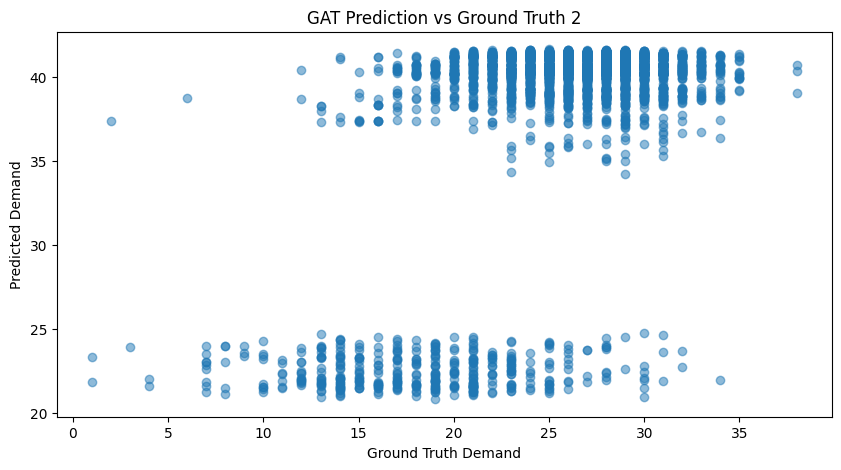

In [146]:
# set random seed
count = 1
for i in range(1, 13):
    print(i)
    val_set = train_files[i]
    train_set = train_files[1:i] + train_files[i+1:]  
    torch.manual_seed(0)

    #GCN model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    GCN_model = GCN(in_channels=9, hidden_channels=9, out_channels=1, dropout=0).to(device)
    GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.005, weight_decay=5e-4)

    GCN_loss_values = []

    GCN_model.train()
    for epoch in range(150):
        total_loss = 0
        for data in train_set:
            GCN_optimizer.zero_grad()
            GCN_out = GCN_model(data)
            GCN_loss = F.mse_loss(GCN_out, data.y.view(-1, 1))
            GCN_loss.backward()
            GCN_optimizer.step()
            GCN_loss_values.append(GCN_loss.item())
            # print(f'Epoch {epoch+1}, Loss: {GCN_loss.item()}')
    avg_loss = sum(GCN_loss_values) / len(train_set)
    loop_gcn_tloss_lst.append(avg_loss)

    #GAT model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    GAT_model = GAT(in_channels=9, hidden_channels=9, out_channels=1, heads=9, dropout=0).to(device)
    GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)

    GAT_loss_values = []

    GAT_model.train()
    for epoch in range(150):
        total_loss = 0
        for data in train_set:
            GAT_optimizer.zero_grad()
            GAT_out = GAT_model(data)
            GAT_loss = F.mse_loss(GAT_out, data.y.view(-1, 1))
            GAT_loss.backward()
            GAT_optimizer.step()
            GAT_loss_values.append(GAT_loss.item())
        # print(f'Epoch {epoch+1}, Loss: {GAT_loss.item()}')
    avg_loss = sum(GAT_loss_values) / len(train_set)
    loop_gat_tloss_lst.append(avg_loss)

    # Evaluate the model
    GCN_model.eval()
    GCN_out = GCN_model(test_file)
    GCN_loss = F.mse_loss(GCN_out, test_file.y.view_as(GCN_out))
    # print(f'GCN_Test Loss: {GCN_loss.item()}')
    loop_gcn_testloss_lst.append(GCN_loss)
    
    GAT_model.eval()
    GAT_out = GAT_model(test_file)
    GAT_loss = F.mse_loss(GAT_out, test_file.y.view_as(GAT_out))
    # print(f'GAT_Test Loss: {GAT_loss.item()}')
    loop_gat_testloss_lst.append(GAT_loss)

    # plot the distribution of original congestion and predicted congestion
    plt.clf()
    plt.figure(figsize=(10, 5))
    sns.histplot(test_file.y.cpu().detach().numpy(), kde=True, label='Ground Truth Demand', stat="density", color='blue')
    sns.histplot(GCN_out.cpu().detach().numpy().flatten(), kde=True, label='Predicted Demand', stat="density", color='red')
    plt.xlabel('Demand')
    plt.ylabel('Frequency')
    plt.title(f'GCN Prediction vs Ground Truth {i}')
    plt.legend()
    plt.savefig(f"loop_gcn_hist/{i}.png")
    # plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    sns.histplot(test_file.y.cpu().detach().numpy(), kde=True, label='Ground Truth Demand', stat="density", color='blue')
    sns.histplot(GAT_out.cpu().detach().numpy().flatten(), kde=True, label='Predicted Demand', stat="density", color='red')
    plt.xlabel('Congestion')
    plt.ylabel('Frequency')
    plt.title(f'GAT Prediction vs Ground Truth {i}')
    plt.legend()
    plt.savefig(f"loop_gat_hist/{i}.png")
    # plt.show()

    plt.clf()
    plt.scatter(test_file.y.cpu().detach().numpy(), GCN_out.cpu().detach().numpy(), alpha=0.5)
    plt.xlabel('Ground Truth Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'GCN Prediction vs Ground Truth {i}')
    plt.savefig(f"loop_gcn_scatter/{i}.png")
    # plt.show()

    plt.clf()
    plt.scatter(test_file.y.cpu().detach().numpy(), GAT_out.cpu().detach().numpy(), alpha=0.5)
    plt.xlabel('Ground Truth Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'GAT Prediction vs Ground Truth {i}')
    plt.savefig(f"loop_gat_scatter/{i}.pdf")

    # calculate Pearson correlation coefficient, kendall correlation coefficient, and test RMSE
    from sklearn.metrics import mean_squared_error
    from scipy.stats import pearsonr, kendalltau

    GCN_rmse = mean_squared_error(test_file.y.cpu().detach().numpy(), GCN_out.cpu().detach().numpy(), squared=False)
    GAT_rmse = mean_squared_error(test_file.y.cpu().detach().numpy(), GAT_out.cpu().detach().numpy(), squared=False)
    loop_gcn_rmse_lst.append(GCN_rmse)
    loop_gat_rmse_lst.append(GAT_rmse)
    
    GCN_pearson = pearsonr(test_file.y.cpu().detach().numpy().flatten(), GCN_out.cpu().detach().numpy().flatten())
    GAT_pearson = pearsonr(test_file.y.cpu().detach().numpy().flatten(), GAT_out.cpu().detach().numpy().flatten())
    loop_gcn_pearson_lst.append(GCN_pearson.statistic)
    loop_gat_pearson_lst.append(GAT_pearson.statistic)

    GCN_kendall = kendalltau(test_file.y.cpu().detach().numpy().flatten(), GCN_out.cpu().detach().numpy().flatten())
    GAT_kendall = kendalltau(test_file.y.cpu().detach().numpy().flatten(), GAT_out.cpu().detach().numpy().flatten())
    loop_gcn_kendall_lst.append(GCN_kendall.correlation)
    loop_gat_kendall_lst.append(GAT_kendall.correlation)

    average_demand = test_file.y.mean()
    naive_mse = mean_squared_error(test_file.y.cpu().detach().numpy(), np.full(test_file.y.shape, average_demand), squared=False)
    loop_naive_mse_lst.append(naive_mse)


In [148]:
loop_gcn_rmse_lst

[11.90242, 11.038518]

In [149]:
loop_gat_rmse_lst


[14.917875, 13.7802515]

In [150]:
loop_gcn_pearson_lst

[-0.16994671958125016, -0.18285738441825972]

In [153]:
loop_gat_pearson_lst

[0.5543643870275674, 0.5547825699792749]

In [152]:
loop_gcn_kendall_lst

[-0.12920309713936942, -0.12464506141000994]

In [151]:
loop_gat_kendall_lst

[0.14963621623875656, 0.14923704173600383]